In [55]:
import pickle
from google.colab import files
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
from geopy.distance import geodesic
from typing import Union


# Utils

In [56]:
def timestamp2dt(timestamp_in_nanos: int = 1695574924084424000):
  timestamp_in_millis = timestamp_in_nanos / 1e6  # Convert to milliseconds
  # Create a datetime object
  dt = datetime.utcfromtimestamp(timestamp_in_millis / 1000)
  # Print the date and time
  return dt

# File upload

In [ ]:
# Upload the "dataset.pkl" file to Colab
uploaded = files.upload()
path = r'C:\Users\joses\Mi unidad\TRABAJO\49_profile_estimation\TRABAJO\experimental\2229-2023-09-24_17-01-55'
# filenames = {'acc': 'AccelerometerUncalibrated.csv',
#              'gyr': 'GyroscopeUncalibrated.csv',
#              'loc': 'Location.csv'}

# 870-2023-09-29_14-45-34
#


In [ ]:
# Load the data from the uploaded file
filenames = {'acc': 'AccelerometerUncalibrated.csv',
             'gyr': 'GyroscopeUncalibrated.csv',
             'loc': 'Location.csv'}


dfs = {k: None for k in filenames.keys()}
for filename in filenames.keys():
  dfs[filename] = pd.read_csv(filenames[filename])


## Time cropping

In [ ]:
# s_min = 2  # m/s
# i_ini = (dfs['loc']['speed'] > s_min).idxmax()
# i_fin = (dfs['loc']['speed'].iloc[i_ini:] < s_min).idxmax()

s_min = 2  # m/s
i_ini = 0
i_fin = 137

t_ini, t_fin = dfs['loc']['seconds_elapsed'].iloc[i_ini], dfs['loc']['seconds_elapsed'].iloc[i_fin]
print(t_ini, '---', t_fin)

print(timestamp2dt(dfs['loc']['time'].iloc[i_ini]), '---', timestamp2dt(dfs['loc']['time'].iloc[i_fin]))

dfs_crop = {}
if s_min > 0:
  dfs_crop['loc'] = dfs['loc'].loc[i_ini:i_fin, :].copy()
  dfs_crop['acc'] = dfs['acc'].loc[(abs(dfs['acc']['seconds_elapsed']-t_ini)).idxmin():(abs(dfs['acc']['seconds_elapsed']-t_fin)).idxmin(), :].copy()
  dfs_crop['gyr'] = dfs['gyr'].loc[(abs(dfs['gyr']['seconds_elapsed']-t_ini)).idxmin():(abs(dfs['gyr']['seconds_elapsed']-t_fin)).idxmin(), :].copy()
else:
  dfs_crop['loc'] = dfs['loc'].copy()
  dfs_crop['acc'] = dfs['acc'].copy()
  dfs_crop['gyr'] = dfs['gyr'].copy()



# Vertical velocity from acc

In [ ]:
# Define a function to integrate 'x' with respect to 'seconds_elapsed'
def integrate_x(df_slice):
    # Calculate the integral of 'x' over 'seconds_elapsed' in the slice
    integral = df_slice.sum()
    return integral

# Remove moving mean
acc_delta_t = 0.01 # s
mean_window_length_s = 10. # s
mean_window = int(mean_window_length_s/acc_delta_t)
dfs_crop['acc']['x_rem_mean'] = dfs_crop['acc']['x'] - (1/mean_window)*dfs_crop['acc'].rolling(
    window=mean_window)['x'].apply(integrate_x, raw=True)
dfs_crop['acc']['y_rem_mean'] = dfs_crop['acc']['y'] - (1/mean_window)*dfs_crop['acc'].rolling(
    window=mean_window)['y'].apply(integrate_x, raw=True)
dfs_crop['acc']['z_rem_mean'] = dfs_crop['acc']['z'] - (1/mean_window)*dfs_crop['acc'].rolling(
    window=mean_window)['z'].apply(integrate_x, raw=True)

# Apply the rolling window and integrate over a 1-second window
window_length_s = 5.00
dfs_crop['acc']['vel_x'] = acc_delta_t*dfs_crop['acc'].rolling(
    window=int(window_length_s/acc_delta_t))['x_rem_mean'].apply(integrate_x, raw=True)
dfs_crop['acc']['vel_y'] = acc_delta_t*dfs_crop['acc'].rolling(
    window=int(window_length_s/acc_delta_t))['y_rem_mean'].apply(integrate_x, raw=True)
dfs_crop['acc']['vel_z'] = acc_delta_t*dfs_crop['acc'].rolling(
    window=int(window_length_s/acc_delta_t))['z_rem_mean'].apply(integrate_x, raw=True)


In [ ]:
# Remove nans
first_not_nan = np.argmin(np.isnan(dfs_crop['acc']['vel_x']))
dfs_crop['acc'] = dfs_crop['acc'].iloc[first_not_nan:, :].copy()


# same valid values for gyroscope
i_ini = (abs(dfs_crop['acc']['seconds_elapsed'].iloc[0] - dfs_crop['gyr']['seconds_elapsed'])).idxmin()
i_fin = (abs(dfs_crop['acc']['seconds_elapsed'].iloc[-1] - dfs_crop['gyr']['seconds_elapsed'])).idxmin()
dfs_crop['gyr'] = dfs_crop['gyr'].loc[i_ini:i_fin, :].copy()

# same valid values for gyroscope
i_ini = (abs(dfs_crop['acc']['seconds_elapsed'].iloc[0] - dfs_crop['loc']['seconds_elapsed'])).idxmin()
i_fin = (abs(dfs_crop['acc']['seconds_elapsed'].iloc[-1] - dfs_crop['loc']['seconds_elapsed'])).idxmin()
dfs_crop['loc'] = dfs_crop['loc'].loc[i_ini:i_fin, :].copy()


# Reset index
dfs_crop['acc'].reset_index(inplace=True)
dfs_crop['gyr'].reset_index(inplace=True)
dfs_crop['loc'].reset_index(inplace=True)


In [ ]:
dfs_crop['acc']

In [ ]:
dfs_crop['gyr']

In [ ]:
dfs_crop['loc']

# File visualization

## Before croping

In [ ]:
fig, ax = plt.subplots(3, 1, sharex='col', figsize=(20,10))
ax[0].plot(dfs['loc']['seconds_elapsed'], dfs['loc']['speed'])
ax[1].plot(dfs['acc']['seconds_elapsed'], dfs['acc']['x'])
ax[1].plot(dfs['acc']['seconds_elapsed'], dfs['acc']['y'])
ax[1].plot(dfs['acc']['seconds_elapsed'], dfs['acc']['z'])
ax[2].plot(dfs['gyr']['seconds_elapsed'], dfs['gyr']['x'])
ax[2].plot(dfs['gyr']['seconds_elapsed'], dfs['gyr']['y'])
ax[2].plot(dfs['gyr']['seconds_elapsed'], dfs['gyr']['z'])
ax[0].set_xlim((max((min(dfs['loc']['seconds_elapsed']), min(dfs['acc']['seconds_elapsed']), min(dfs['gyr']['seconds_elapsed'])))),
                min((max(dfs['loc']['seconds_elapsed']), max(dfs['acc']['seconds_elapsed']), max(dfs['gyr']['seconds_elapsed']))))

## After cropping

In [ ]:
set_xlim = False

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].plot(dfs_crop['loc']['seconds_elapsed'], dfs_crop['loc']['speed'])
ax[1].plot(dfs_crop['loc']['longitude'], dfs_crop['loc']['latitude'])

fig, ax = plt.subplots(4, 1, sharex='col', figsize=(20,10))
ax[0].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['x'], label='x')
ax[0].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['y'], label='y')
ax[0].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['z'], label='z')
ax[0].set_ylabel('acceleration (m/s2)')
ax[1].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['x_rem_mean'], label='x')
ax[1].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['y_rem_mean'], label='y')
ax[1].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['z_rem_mean'], label='z')
ax[1].set_ylabel('rem. mean acceleration (m/s2)')
ax[1].legend()
ax[2].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['vel_x'], label='x')
ax[2].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['vel_y'], label='y')
ax[2].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['vel_z'], label='z')
ax[2].set_ylabel('windowed velocity (m/s)')
ax[2].legend()
ax[3].plot(dfs_crop['gyr']['seconds_elapsed'], dfs_crop['gyr']['x'], label='x')
ax[3].plot(dfs_crop['gyr']['seconds_elapsed'], dfs_crop['gyr']['y'], label='y')
ax[3].plot(dfs_crop['gyr']['seconds_elapsed'], dfs_crop['gyr']['z'], label='z')
ax[3].set_ylabel('gyro velocity (rad/s)')
ax[3].set_xlabel('time (s)')
ax[3].legend()
if set_xlim:
  ax[0].set_xlim((max((min(dfs['loc']['seconds_elapsed']), min(dfs['acc']['seconds_elapsed']), min(dfs['gyr']['seconds_elapsed'])))),
                  min((max(dfs['loc']['seconds_elapsed']), max(dfs['acc']['seconds_elapsed']), max(dfs['gyr']['seconds_elapsed']))))

# Auto correlation in time and space domain

## Pass to space domain

In [ ]:
dfs_crop['loc'].loc[:, 'distance_from_speed'] = dfs_crop['loc'].loc[:, 'speed'].cumsum()

# Replace NaN values with zeros in the 'latitude' and 'longitude' columns
dfs_crop['loc']['latitude'].fillna(0, inplace=True)
dfs_crop['loc']['longitude'].fillna(0, inplace=True)

# Create an empty list to store distances
distances = []

# Iterate over the DataFrame rows, skipping the first and last rows
for i in range(1, len(dfs_crop['loc']) - 1):
    lat1 = dfs_crop['loc']['latitude'].iloc[i - 1]
    lon1 = dfs_crop['loc']['longitude'].iloc[i - 1]
    lat2 = dfs_crop['loc']['latitude'].iloc[i + 1]
    lon2 = dfs_crop['loc']['longitude'].iloc[i + 1]
    distance = geodesic((lat1, lon1), (lat2, lon2)).m
    distances.append(distance)

# Add the distances to the DataFrame
dfs_crop['loc']['distances'] = [None] + distances + [None]
dfs_crop['loc']['distance_from_latlong'] = dfs_crop['loc']['distances'].cumsum()
# dfs_crop['loc']

## Autocorrelation in space domain

### Using distance from speed

In [ ]:
dfs_crop['acc']['speed'] = np.nan
dfs_crop['gyr']['speed'] = np.nan

for t, s in zip(dfs_crop['loc']['seconds_elapsed'],
                dfs_crop['loc']['speed']):
  id = (abs(t - dfs_crop['acc']['seconds_elapsed'])).idxmin()
  dfs_crop['acc']['speed'][id] = s

for t, s in zip(dfs_crop['loc']['seconds_elapsed'],
                dfs_crop['loc']['speed']):
  id = (abs(t - dfs_crop['gyr']['seconds_elapsed'])).idxmin()
  dfs_crop['gyr']['speed'][id] = s

dfs_crop['acc']['speed'].interpolate('cubicspline', inplace=True)
dfs_crop['acc']['distance_from_speed'] = acc_delta_t*dfs_crop['acc']['speed'].cumsum()

dfs_crop['gyr']['speed'].interpolate('cubicspline', inplace=True)
dfs_crop['gyr']['distance_from_speed'] = acc_delta_t*dfs_crop['gyr']['speed'].cumsum()


In [ ]:
dfs_crop['acc']

In [ ]:
dfs_crop['gyr']

In [ ]:
delta_space = 0.01  # m

dfs_crop_space = {}

distance_from_speed = np.arange(0, dfs_crop['acc']['distance_from_speed'].iloc[-1], delta_space)
dfs_crop_space['acc'] = pd.DataFrame({'distance_from_speed': distance_from_speed,
                                      'x_rem_mean': np.interp(distance_from_speed, dfs_crop['acc']['distance_from_speed'], dfs_crop['acc']['x_rem_mean']),
                                      'y_rem_mean': np.interp(distance_from_speed, dfs_crop['acc']['distance_from_speed'], dfs_crop['acc']['y_rem_mean']),
                                      'z_rem_mean': np.interp(distance_from_speed, dfs_crop['acc']['distance_from_speed'], dfs_crop['acc']['z_rem_mean']),
                                      'vel_x': np.interp(distance_from_speed, dfs_crop['acc']['distance_from_speed'], dfs_crop['acc']['vel_x']),
                                      'vel_y': np.interp(distance_from_speed, dfs_crop['acc']['distance_from_speed'], dfs_crop['acc']['vel_y']),
                                      'vel_z': np.interp(distance_from_speed, dfs_crop['acc']['distance_from_speed'], dfs_crop['acc']['vel_z'])})
dfs_crop_space['gyr'] = pd.DataFrame({'distance_from_speed': distance_from_speed,
                                      'x': np.interp(distance_from_speed, dfs_crop['gyr']['distance_from_speed'], dfs_crop['gyr']['x']),
                                      'y': np.interp(distance_from_speed, dfs_crop['gyr']['distance_from_speed'], dfs_crop['gyr']['y']),
                                      'z': np.interp(distance_from_speed, dfs_crop['gyr']['distance_from_speed'], dfs_crop['gyr']['z'])})

fig, ax = plt.subplots(2, 2, figsize=(20,10))
ax[0, 0].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['vel_z'])
ax[0, 0].set_ylabel('vert. velocity')
ax[0, 0].set_xlabel('time (s)')
ax[0, 1].plot(dfs_crop_space['acc']['distance_from_speed'], dfs_crop_space['acc']['vel_z'])
ax[0, 1].set_ylabel('vert. velocity')
ax[0, 1].set_xlabel('distance (m)')

ax[1, 0].plot(dfs_crop['gyr']['seconds_elapsed'], dfs_crop['gyr']['x'])
ax[1, 0].set_ylabel('gyr. velocity')
ax[1, 0].set_xlabel('time (s)')
ax[1, 1].plot(dfs_crop_space['gyr']['distance_from_speed'], dfs_crop_space['gyr']['x'])
ax[1, 1].set_ylabel('gyr. velocity')
ax[1, 1].set_xlabel('distance (m)')

# dfs_crop_space['acc']

In [ ]:
# Calculates autocorrelation function in time domain
autocorrelation_z_acc = []
autocorrelation_x_gyr = []
lags = 200
for lag in range(lags):
  autocorrelation_z_acc.append(dfs_crop['acc']['z_rem_mean'].autocorr(lag))
  autocorrelation_x_gyr.append(dfs_crop['gyr']['x'].autocorr(lag))
autocorrelation_z_acc = np.array(autocorrelation_z_acc)
autocorrelation_x_gyr = np.array(autocorrelation_x_gyr)

# Calculates autocorrelation function in space domain
autocorrelation_space_z_acc = []
autocorrelation_space_x_gyr = []
lags = 300
for lag in range(lags):
  autocorrelation_space_z_acc.append(dfs_crop_space['acc']['z_rem_mean'].autocorr(lag))
  autocorrelation_space_x_gyr.append(dfs_crop_space['gyr']['x'].autocorr(lag))
autocorrelation_space_z_acc = np.array(autocorrelation_space_z_acc)
autocorrelation_space_x_gyr = np.array(autocorrelation_space_x_gyr)

# Plots autocorrelation function of vertical acc
fig, ax = plt.subplots(3, 2, sharey='row', figsize=(15, 15))
ax[0,0].plot(autocorrelation_space_z_acc)
ax[0,0].set_title('Autocorrelation in space domain')
ax[0,0].set_xlabel(f'Lag (1 = {delta_space} m)')
ax[0,0].set_ylabel('Autocorrelation of z acc.')
ax[0,0].minorticks_on()
ax[0,0].grid(which='both')

ax[0,1].plot(autocorrelation_z_acc)
ax[0,1].set_title('Autocorrelation in time domain')
ax[0,1].set_xlabel(f'Lag (1 = {acc_delta_t} s)')
ax[0,1].minorticks_on()
ax[0,1].grid(which='both')

# Plots autocorrelation function of gyr
ax[1,0].plot(autocorrelation_space_x_gyr)
ax[1,0].set_title('Autocorrelation in space domain')
ax[1,0].set_xlabel(f'Lag (1 = {delta_space} m)')
ax[1,0].set_ylabel('Autocorrelation of x gyr.')
ax[1,0].minorticks_on()
ax[1,0].grid(which='both')

ax[1,1].plot(autocorrelation_x_gyr)
ax[1,1].set_title('Autocorrelation in time domain')
ax[1,1].set_xlabel(f'Lag (1 = {acc_delta_t} s)')
ax[1,1].minorticks_on()
ax[1,1].grid(which='both')

# Plots product of autocorrelations
ax[2,0].plot(autocorrelation_space_x_gyr * autocorrelation_space_z_acc)
ax[2,0].set_title('Autocorrelation in space domain')
ax[2,0].set_xlabel(f'Lag (1 = {delta_space} m)')
ax[2,0].set_ylabel('Product of Autocorrelations')
ax[2,0].minorticks_on()
ax[2,0].grid(which='both')

ax[2,1].plot(autocorrelation_x_gyr * autocorrelation_z_acc)
ax[2,1].set_title('Autocorrelation in time domain')
ax[2,1].set_xlabel(f'Lag (1 = {acc_delta_t} s)')
ax[2,1].minorticks_on()
ax[2,1].grid(which='both')


plt.show()

### Longitudinal acceleration

In [ ]:
tlims = (0, 170)
plt.figure(figsize=(15,6))
plt.plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['vel_y'])
plt.plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['speed'] - dfs_crop['acc']['speed'].mean())
plt.xlabel('time (s)')
plt.ylabel('y velocity')
plt.xlim(tlims)

plt.figure(figsize=(15,6))
plt.plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['y_rem_mean'])
plt.plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['speed'].diff()/acc_delta_t)
plt.xlabel('time (s)')
plt.ylabel('y acceleration')
plt.xlim(tlims)

# Spectrograms

## Spectrograms of temporal frequency

### Utils

In [ ]:
def batch_extractor(time: np.ndarray, response: np.ndarray, batch_length_s: float, ret_time_batches: bool = False,
                    runing: bool = True, as_nparray: bool = False):
    time_batches = []
    response_batches = []
    if runing:
        batch_length = int(batch_length_s // (time[1] - time[0]))
        n_batches = len(time) - batch_length
    else:
        n_batches = int(time[-1] // batch_length_s)
        batch_length = int(len(time) // n_batches)
    for i_batch in range(n_batches):
        if runing:
            i_ini, i_fin = i_batch, i_batch + batch_length
        else:
            i_ini, i_fin = i_batch * batch_length, (i_batch + 1) * batch_length
        time_batches.append(time[i_ini:i_fin])
        response_batches.append(response[i_ini:i_fin])
    if ret_time_batches:
        if as_nparray:
            return np.array(response_batches), np.array(time_batches)
        else:
            return response_batches, time_batches
    else:
        if as_nparray:
            return np.array(response_batches)
        else:
            return response_batches


### Calculation

In [ ]:
batch_length_s = 2.

assert (dfs_crop['acc']['seconds_elapsed'].values == dfs_crop['gyr']['seconds_elapsed'].values).all()
assert (dfs_crop['acc']['distance_from_speed'].values == dfs_crop['gyr']['distance_from_speed'].values).all()

## Vertical acceleration
x_acc = dfs_crop['acc']['z_rem_mean'].values
time = dfs_crop['acc']['seconds_elapsed'].values
distance = dfs_crop['acc']['distance_from_speed'].values

delta_t = acc_delta_t
x_acc_batches, x_time_batches = batch_extractor(time, x_acc, batch_length_s, runing=True,
                                                ret_time_batches=True, as_nparray=True)
x_distance_batches = batch_extractor(time, distance, batch_length_s, runing=True,
                                     ret_time_batches=False, as_nparray=True)
batch_size = x_acc_batches.shape[1]

# Frequency domain
freq = np.fft.fftfreq(len(x_time_batches[0]), delta_t)[:batch_size // 2]
x_acc_batches_fd = np.abs(np.fft.fft(x_acc_batches, axis=1))[:, :batch_size // 2]
input_shape = (x_acc_batches_fd.shape[1],)


## Transversal gyr. velocity
x_gyr = dfs_crop['gyr']['x'].values
x_gyr_batches, _ = batch_extractor(time, x_gyr, batch_length_s, runing=True,
                                   ret_time_batches=True, as_nparray=True)

# Frequency domain
x_gyr_batches_fd = np.abs(np.fft.fft(x_gyr_batches, axis=1))[:, :batch_size // 2]



### Pass to space domain

In [ ]:
delta_space = 0.01  # m

reg_distance = np.arange(x_distance_batches[0, 0],
                         x_distance_batches[-1, 0], delta_space)

## Vertical acceleration
x_acc_batches_fd_distance = np.zeros((reg_distance.shape[0], x_acc_batches_fd.shape[1]))
for i in range(x_acc_batches_fd.shape[1]):
  x_acc_batches_fd_distance[:, i] = np.interp(reg_distance, x_distance_batches[:, 0], x_acc_batches_fd[:, i])

## Transversal gyr. velocity
x_gyr_batches_fd_distance = np.zeros((reg_distance.shape[0], x_gyr_batches_fd.shape[1]))
for i in range(x_gyr_batches_fd.shape[1]):
  x_gyr_batches_fd_distance[:, i] = np.interp(reg_distance, x_distance_batches[:, 0], x_gyr_batches_fd[:, i])


### Plot in time domain

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex='all')
ax[0].imshow(x_acc_batches_fd, extent=[freq[0], freq[-1], x_time_batches[-1, 0], x_time_batches[0, 0]],
             aspect='auto', cmap='viridis')
ax[0].set_xlabel('frequency (Hz)')
ax[0].set_ylabel('time (s)')
ax[0].minorticks_on()
ax[0].set_title('Spectrogram of vert. acc.')

ax[1].imshow(x_gyr_batches_fd, extent=[freq[0], freq[-1], x_time_batches[-1, 0], x_time_batches[0, 0]],
             aspect='auto', cmap='viridis')
ax[1].set_xlabel('frequency (Hz)')
ax[1].set_ylabel('time (s)')
ax[1].minorticks_on()
ax[1].set_title('Spectrogram of transv. gyr. vel.')

ax[0].set_xlim([0, 25])

### Plot in space domain

(0.0, 25.0)

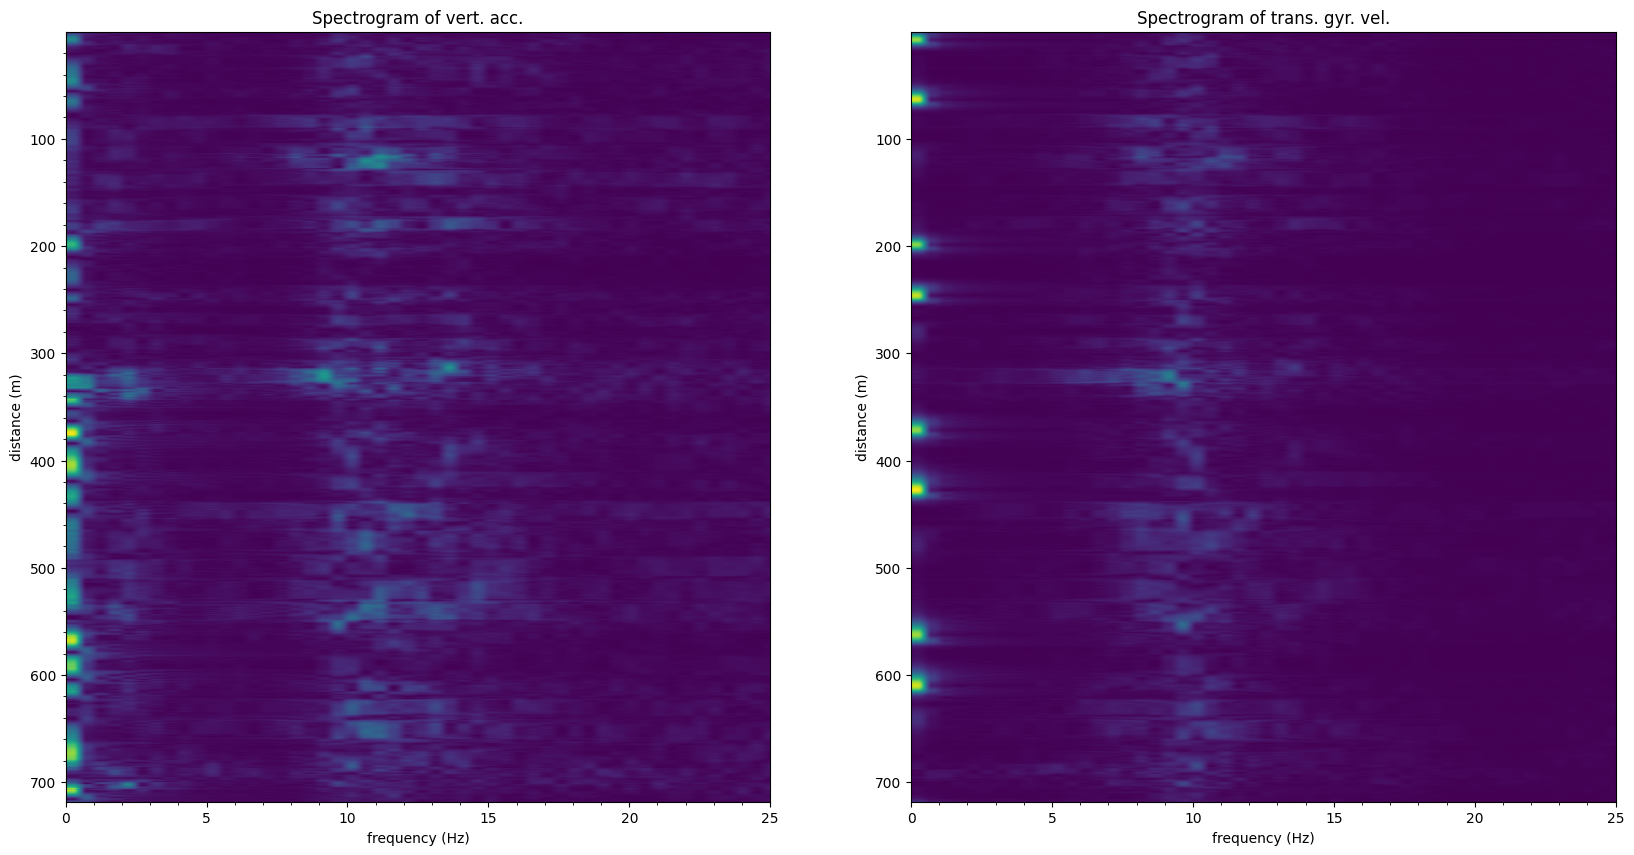

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex='all')

ax[0].minorticks_on()
ax[0].imshow(x_acc_batches_fd_distance, extent=[freq[0], freq[-1], x_distance_batches[-1, 0], x_distance_batches[0, 0]], aspect='auto',
           cmap='viridis')
ax[0].set_xlabel('frequency (Hz)')
ax[0].set_ylabel('distance (m)')
ax[0].set_title('Spectrogram of vert. acc.')

ax[1].imshow(x_gyr_batches_fd_distance, extent=[freq[0], freq[-1], x_distance_batches[-1, 0], x_distance_batches[0, 0]], aspect='auto',
           cmap='viridis')
ax[1].set_xlabel('frequency (Hz)')
ax[1].set_ylabel('distance (m)')
ax[1].set_title('Spectrogram of trans. gyr. vel.')

ax[1].set_xlim([0, 25])

# Predictive models

In [ ]:
from keras.models import Sequential
from keras.layers import Normalization
from keras.optimizers import Adam
from keras import regularizers, Input
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.src.layers import Conv1D, Lambda, Layer

In [ ]:
class DiagonalDense(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer,
                 polynomial_kernel_degree: Union[None, int] = None,
                 inverse_layer=None, **kwargs):
        if polynomial_kernel_degree is not None:
            assert isinstance(polynomial_kernel_degree, int)
            assert polynomial_kernel_degree < units
        self.polynomial_kernel_degree = polynomial_kernel_degree
        self.kernel_initializer = kernel_initializer
        self.kernel = None
        self.kernel_coef = None
        self.kernel_basis = None
        self.units = units
        self.inverse_layer = inverse_layer
        super(DiagonalDense, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.polynomial_kernel_degree is None:
            self.kernel = self.add_weight("kernel", shape=(self.units,), initializer=self.kernel_initializer,
                                          trainable=True, constraint=tf.keras.constraints.NonNeg())
        else:
            self.kernel_coef = self.add_weight("kernel_coef", shape=(self.polynomial_kernel_degree, 1),
                                              initializer=self.kernel_initializer, trainable=True)
            self.kernel = self.add_weight("kernel", shape=(self.units,), initializer=self.kernel_initializer,
                                          trainable=False, constraint=tf.keras.constraints.NonNeg())
            # Define the degree of the Legendre polynomial
            degree = self.polynomial_kernel_degree  # Replace with your degree value
            length = self.units
            domain = (0, length - 1)
            basis = np.zeros((length, degree))
            for row in range(length):  # Calculate Legendre polynomials for each row
                for col in range(degree):
                    polynomial = np.polynomial.legendre.Legendre.basis(col, domain)
                    # Evaluate the Legendre polynomial at the desired point (0.0 for Legendre polynomials)
                    basis[row, col] = polynomial(row)
            self.kernel_basis = self.add_weight("basis", shape=(length, degree), initializer='ones',
                                                trainable=False)
            self.kernel_basis.assign(basis)
        if self.inverse_layer is not None:
            self.kernel = self.add_weight("kernel", shape=(self.units,), initializer=self.kernel_initializer,
                                          trainable=False, constraint=tf.keras.constraints.NonNeg())
        super(DiagonalDense, self).build(input_shape)
    def call(self, inputs, **kwargs):
        if self.polynomial_kernel_degree is None:
            if self.inverse_layer is None:
                z = self.kernel * inputs
            else:
                kernel = 1/self.inverse_layer.kernel
                self.kernel.assign(tf.reshape(kernel, (-1,)))
                z = tf.reshape(kernel, (-1,)) * inputs
        else:
            kernel = self.kernel_basis @ self.kernel_coef
            self.kernel.assign(tf.reshape(kernel, (-1,)))
            z = tf.reshape(kernel, (-1,)) * inputs
        return z



## Autoencoder of spectrograms

#### Normalization

In [ ]:
# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Fit the scaler to your data and transform it
x_acc_batches_fd_distance_normalized = scaler.fit_transform(x_acc_batches_fd_distance)
x_gyr_batches_fd_distance_normalized = scaler.fit_transform(x_gyr_batches_fd_distance)

In [1]:
pd.DataFrame(x_acc_batches_fd_distance_normalized).describe()

NameError: ignored

In [52]:
# pd.DataFrame(x_gyr_batches_fd_distance_normalized).describe()

In [53]:
learning_rate = 0.0005
epochs = 10
batch_size = 64

input_shape = (x_acc_batches_fd_distance.shape[1], )

input_x1 = Input(shape=input_shape)
input_x2 = Input(shape=input_shape)

# Apply DiagonalDense to each input (inverse systems)
diag1 = DiagonalDense(units=input_shape[0], kernel_initializer='ones',
                      polynomial_kernel_degree=None)
diag2 = DiagonalDense(units=input_shape[0], kernel_initializer='ones',
                      polynomial_kernel_degree=None)

# Bottle neck for the latent space of spectrograms (hopefully road spectrograms)
latent = (diag1(input_x1) + diag2(input_x2))/2

# Apply DiagonalDense to each input (direct systems)
diag_y1 = DiagonalDense(units=input_shape[0], kernel_initializer='ones',
                        polynomial_kernel_degree=None,
                        inverse_layer=diag1)(latent)
diag_y2 = DiagonalDense(units=input_shape[0], kernel_initializer='ones',
                        polynomial_kernel_degree=None,
                        inverse_layer=diag2)(latent)

# Create the model
model = tf.keras.models.Model(inputs=[input_x1, input_x2],
                              outputs=[diag_y1, diag_y2])

# Compile the model and specify loss and optimizer as needed
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='mse')
model.summary()

model.fit(x=[x_acc_batches_fd_distance_normalized, x_gyr_batches_fd_distance_normalized],
          y=[x_acc_batches_fd_distance_normalized, x_gyr_batches_fd_distance_normalized],
          epochs=epochs, batch_size=batch_size, shuffle=True,
          validation_split=0.1)



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 diagonal_dense_8 (Diagonal  (None, 100)                  100       ['input_5[0][0]']             
 Dense)                                                                                           
                                                                                                  
 diagonal_dense_9 (Diagonal  (None, 100)                  100       ['input_6[0][0]']       

### Kernel plotting

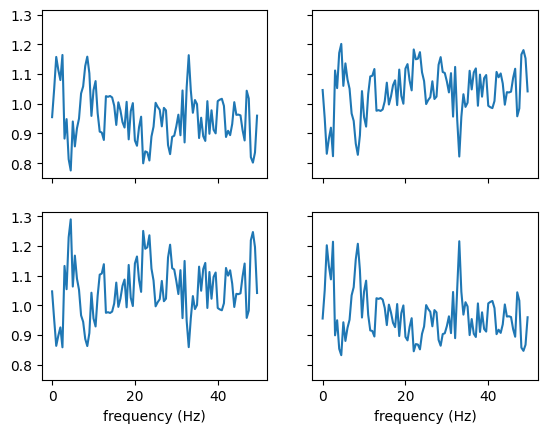

In [54]:
kernels = np.array([[None, None], [None, None]])
kernels[0, 0] = next((var for var in model.layers[2].variables if 'kernel:' in var.name), None)
kernels[0, 1] = next((var for var in model.layers[3].variables if 'kernel:' in var.name), None)
kernels[1, 0] = model.layers[6].variables[1].numpy()
kernels[1, 1] = model.layers[7].variables[1].numpy()

fig, ax = plt.subplots(2, 2, sharex='all', sharey='all')
for i, j in [[0, 0], [0, 1], [1, 0], [1, 1]]:
  ax[i, j].plot(freq, kernels[i, j])
  if i > 0:
    ax[i, j].set_xlabel('frequency (Hz)')
  # ax[i, j].set_ylim([0.01, 10])
  # ax[i, j].set_yscale('log')

# ax[0, 0].set_xlim([0, 25])

## Latent spectrogram

### Inference

In [29]:
# Get the layer representing the latent space from your trained model
latent_layer = model.layers[4]  # Adjust the index as needed

# Create an inference model that takes an input and produces the latent representation
inference_model = tf.keras.models.Model(inputs=model.input, outputs=latent_layer.output)

# Now, you can use this inference model to obtain the latent representation from input data
latent_representation = inference_model.predict(x=[x_acc_batches_fd_distance, x_gyr_batches_fd_distance])

2245/2245 [==============================] - 4s 2ms/step


In [30]:
# Get the predicted output
y_acc_batches_fd_distance, y_gyr_batches_fd_distance = model.predict(x=[x_acc_batches_fd_distance, x_gyr_batches_fd_distance])

2245/2245 [==============================] - 4s 2ms/step


### Plotting of spectrograms

(0.0, 25.0)

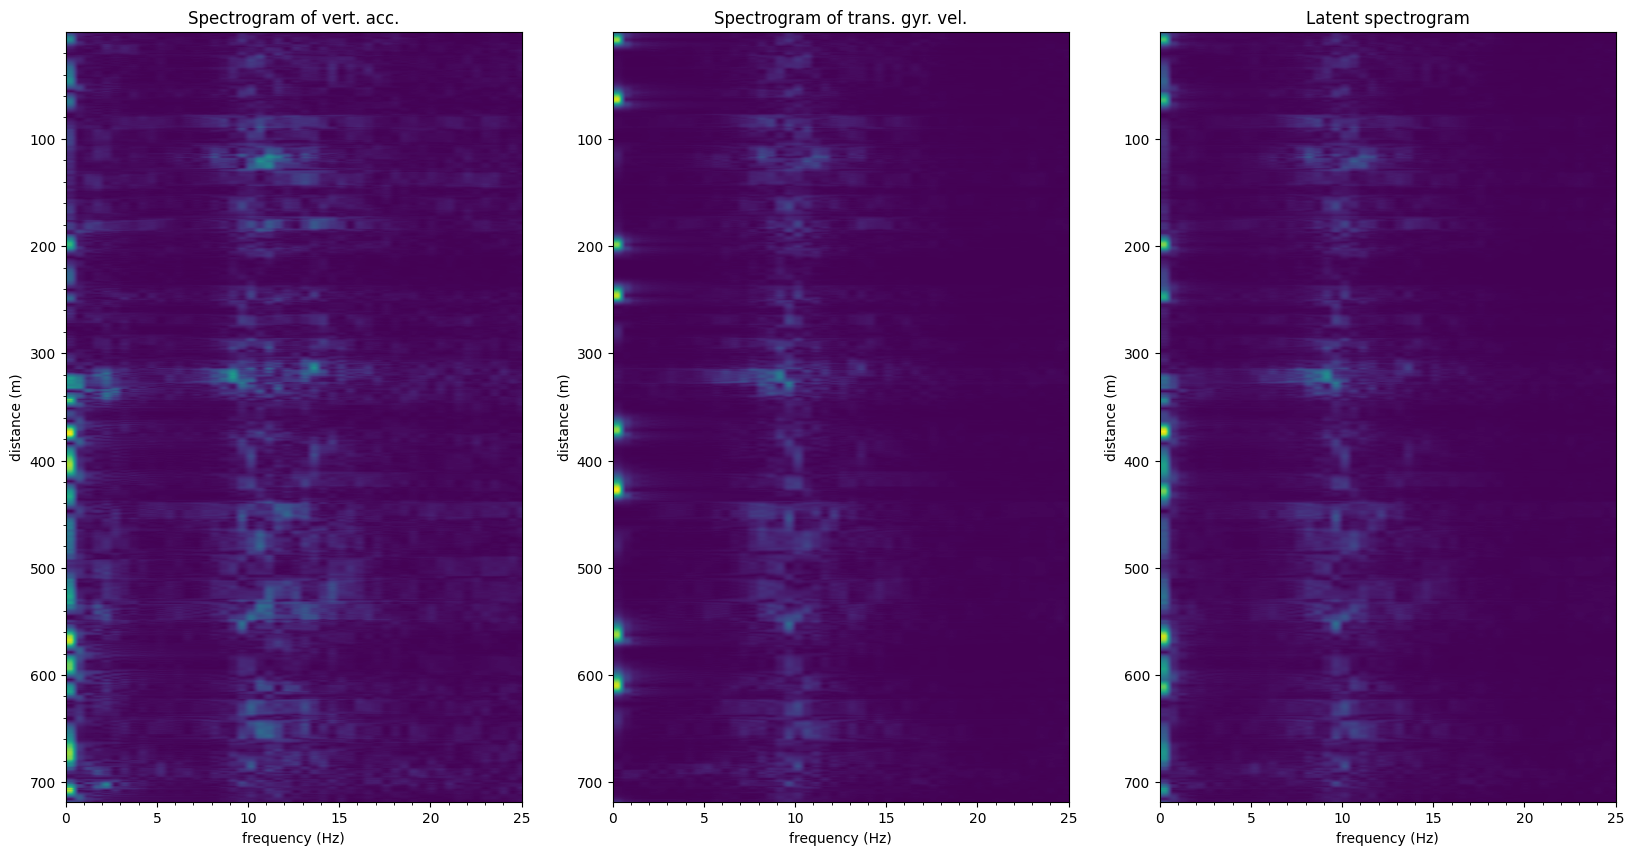

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10), sharex='all')

ax[0].minorticks_on()
ax[0].imshow(x_acc_batches_fd_distance, extent=[freq[0], freq[-1], x_distance_batches[-1, 0], x_distance_batches[0, 0]], aspect='auto',
           cmap='viridis')
ax[0].set_xlabel('frequency (Hz)')
ax[0].set_ylabel('distance (m)')
ax[0].set_title('Spectrogram of vert. acc.')

ax[1].imshow(x_gyr_batches_fd_distance, extent=[freq[0], freq[-1], x_distance_batches[-1, 0], x_distance_batches[0, 0]], aspect='auto',
           cmap='viridis')
ax[1].set_xlabel('frequency (Hz)')
ax[1].set_ylabel('distance (m)')
ax[1].set_title('Spectrogram of trans. gyr. vel.')

ax[2].imshow(latent_representation, extent=[freq[0], freq[-1], x_distance_batches[-1, 0], x_distance_batches[0, 0]], aspect='auto',
           cmap='viridis')
ax[2].set_xlabel('frequency (Hz)')
ax[2].set_ylabel('distance (m)')
ax[2].set_title('Latent spectrogram')

ax[2].set_xlim([0, 25])

# Plot predicted spectrograms

(0.0, 25.0)

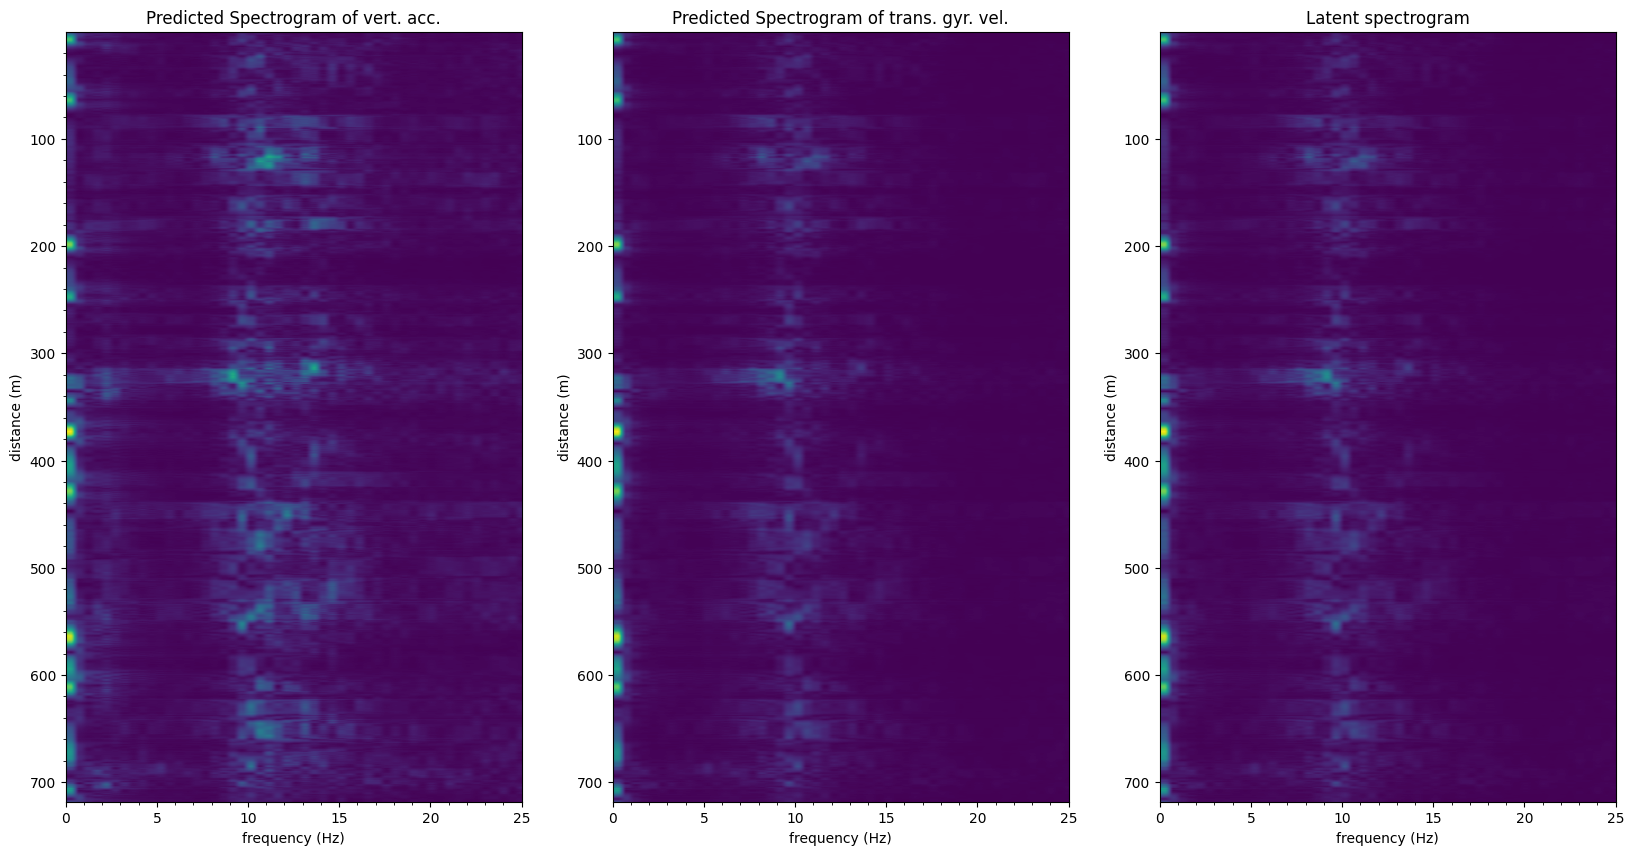

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10), sharex='all')

ax[0].minorticks_on()
ax[0].imshow(y_acc_batches_fd_distance, extent=[freq[0], freq[-1], x_distance_batches[-1, 0], x_distance_batches[0, 0]], aspect='auto',
           cmap='viridis')
ax[0].set_xlabel('frequency (Hz)')
ax[0].set_ylabel('distance (m)')
ax[0].set_title('Predicted Spectrogram of vert. acc.')

ax[1].imshow(y_gyr_batches_fd_distance, extent=[freq[0], freq[-1], x_distance_batches[-1, 0], x_distance_batches[0, 0]], aspect='auto',
           cmap='viridis')
ax[1].set_xlabel('frequency (Hz)')
ax[1].set_ylabel('distance (m)')
ax[1].set_title('Predicted Spectrogram of trans. gyr. vel.')

ax[2].imshow(latent_representation, extent=[freq[0], freq[-1], x_distance_batches[-1, 0], x_distance_batches[0, 0]], aspect='auto',
           cmap='viridis')
ax[2].set_xlabel('frequency (Hz)')
ax[2].set_ylabel('distance (m)')
ax[2].set_title('Latent spectrogram')

ax[2].set_xlim([0, 25])